<a href="https://colab.research.google.com/github/Omkar2703/NLP_CollabProject/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis**

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**EDA Analysis**

In [3]:
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

**Feature Engineering**

In [4]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

**Model Selection and Evaluation**

In [5]:
# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



---



# The Dataset

*The dataset that we will use is taken from `Kaggle` website and can be downloaded here:*

[`Amazon Musical Instruments Reviews`](https://www.kaggle.com/eswarchandt/amazon-music-reviews?select=Musical_instruments_reviews.csv)

*There are two formats available of the dataset: `JSON` and `CSV`. We will use the `CSV` one in this project.*

*Overall, the dataset talks about the feedback received after the customers purchased musical instruments from `Amazon`.*

**Read The Dataset**

In [6]:
dataset = pd.read_csv("Instruments_Reviews.csv")

**Shape of The Dataset**

In [7]:
dataset.shape

(10261, 9)

# Data Preprocessing

**Checking Null Values**

In [8]:
dataset.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


*From above, there are two columns in the dataset with null values: `reviewText` and `reviewerName`. While the latter one is not really important, we should focus on the first column. We cannot remove these rows because the ratings and summary given from the customers will have some effects to our model later (although the number of missing rows is small). Because of it, we can fill the empty values with an empty string.*

**Filling Missing Values**

In [9]:
dataset.reviewText.fillna(value = "", inplace = True)

<ipython-input-9-0ccac16fc17e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset.reviewText.fillna(value = "", inplace = True)


**Concatenate `reviewText` and `summary` Columns**

In [10]:
dataset["reviews"] = dataset["reviewText"] + " " + dataset["summary"]
dataset.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

**Statistic Description of The Dataset**

In [11]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","Not much to write about here, but it does exac..."
freq,42,163,66,6796,NaN,NaN,40,1
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN


*From the description above, we know that the ratings given from the customers will have the range of [1, 5] as shown above. Also, the average rating given to musical instruments sold is 4.48. We can also see our new column `reviews` is there to concate both `summary` and `reviewText`.*

**Percentages of Ratings Given from The Customers**

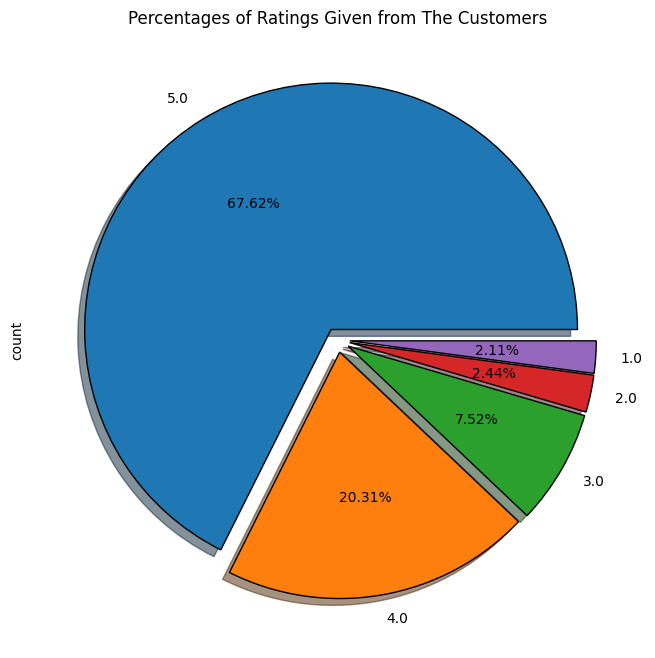

In [12]:
import matplotlib.pyplot as plt

# Assuming `dataset.overall.value_counts()` is a pandas Series
dataset.overall.value_counts().plot(
    kind="pie",
    legend=False,
    autopct="%1.2f%%",
    fontsize=10,
    figsize=(8,8),
    wedgeprops={"edgecolor": "black", "linewidth": 1, "linestyle": "solid", "antialiased": True},
    explode=[0.05] * len(dataset.overall.value_counts()), # Adds spacing between slices
    shadow=True
)

plt.title("Percentages of Ratings Given from The Customers", loc="center")
plt.show()


*From the chart above, the majority of musical instruments sold on Amazon have perfect ratings of 5.0, meaning the condition of the products are good. If we were to denote that ratings above 3 are `positive`, ratings equal to 3 are `neutral`, and ratings under 3 are `negative`, we know that the number of negative reviews given in the dataset are relatively small. This might affect our model later.*

**Labelling Products Based On Ratings Given**

*Our dataset does not have any dependent variable, or in other words we haven't had any prediction target yet. We will categorize each sentiment according to ratings given for each row based on the explanation before: `Positive` Label for products with rating bigger than 3.0, `Neutral` Label for products with rating equal to 3.0, else `Negative` Label.*

In [13]:
def Labelling(Rows):
  if(Rows["overall"] > 3.0):
    Label = "Positive"
  elif(Rows["overall"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label

In [14]:
dataset["sentiment"] = dataset.apply(Labelling, axis = 1)

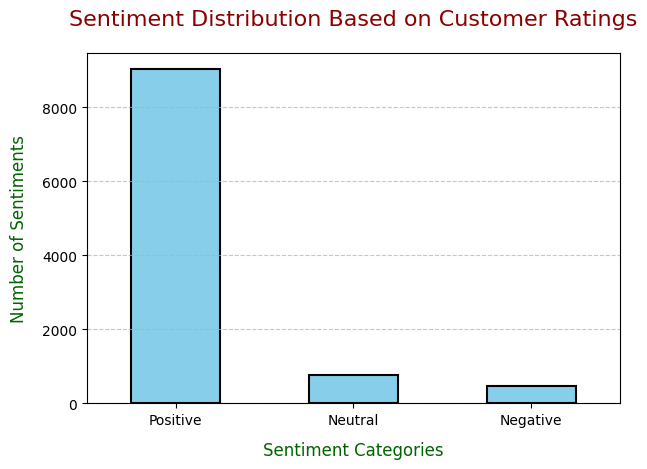

In [15]:
dataset["sentiment"].value_counts().plot(
    kind="bar",
    color="skyblue",                # Changed the bar color to a lighter blue
    edgecolor="black",              # Added black edges to the bars for better distinction
    linewidth=1.5
)

plt.title(
    "Sentiment Distribution Based on Customer Ratings",  # Updated title for clarity
    loc="center",
    fontsize=16,
    color="darkred",             # Changed title color to a darker red
    pad=20
)
plt.xlabel("Sentiment Categories", color="darkgreen", fontsize=12, labelpad=10)
plt.xticks(rotation=0, fontsize=10)                     # Kept the labels upright but changed font size
plt.ylabel("Number of Sentiments", color="darkgreen", fontsize=12, labelpad=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)           # Added gridlines for the y-axis for better readability
plt.tight_layout()                                      # Adjust layout to prevent overlapping
plt.show()

*In this part we can actually change the labels into numeric values but for the sake of experiments we will do it later. Also, notice that from the graph we can know that most of our data contains positive sentiments, which is true from the exploration before.*



---



# Text Preprocessing

**Text Cleaning**

In [16]:
def Text_Cleaning(Text):
  # Lowercase the texts
  Text = Text.lower()

  # Cleaning punctuations in the text
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)

  # Removing numbers in the text
  Text = re.sub(r'\d+', '', Text)

  # Remove possible links
  Text = re.sub('https?://\S+|www\.\S+', '', Text)

  # Deleting newlines
  Text = re.sub('\n', '', Text)

  return Text

**Text Processing**

In [17]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)

  # Removing Stopwords and Lemmatizing Words
  # To reduce noises in our dataset, also to keep it simple and still
  # powerful, we will only omit the word `not` from the list of stopwords

  for word in Tokens:
    if word not in Stopwords:
      Processed_Text.append(Lemmatizer.lemmatize(word))

  return(" ".join(Processed_Text))

**Applying The Functions**

In [18]:
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Cleaning(Text))
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Processing(Text))



---



# Exploratory Data Analysis

**Overview of The Dataset**

In [19]:
dataset.head(n = 10)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sou...,Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized ...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwis...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop ...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio fil...,Positive
5,A2A039TZMZHH9Y,B00004Y2UT,"Bill Lewey ""blewey""","[0, 0]",5.0,1356048000,"12 21, 2012",good bought another one love heavy cord gold c...,Positive
6,A1UPZM995ZAH90,B00004Y2UT,Brian,"[0, 0]",5.0,1390089600,"01 19, 2014",used monster cable year good reason lifetime w...,Positive
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",3.0,1353024000,"11 16, 2012",use cable run output pedal chain input fender ...,Neutral
8,A3M1PLEYNDEYO8,B00004Y2UT,"G. Thomas ""Tom""","[0, 0]",5.0,1215302400,"07 6, 2008",perfect epiphone sheraton ii monster cable wel...,Positive
9,AMNTZU1YQN1TH,B00004Y2UT,Kurt Robair,"[0, 0]",5.0,1389139200,"01 8, 2014",monster make best cable lifetime warranty does...,Positive


*With the overview above, we know that for sentiment analysis that we will do, `reviews` is important to our model and we should use this aspect as our feature. By using this feature, we will need to predict what our sentiment will be classified into.*

**About Other Features**

In [20]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10254,3
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013",good string five star,Positive
freq,42,163,66,6796,NaN,NaN,40,3,9022
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN,NaN


*Now, we will go back to statistic description of our dataset. Intuitively, the other features from our dataset does not really have any impact in determining our sentiment later. We might use the `helpful` part in our model, but as we can see from the description above, the top values of it is [0,0], which means that most users do not really take their votes in it. Because of it, we can also decide that we don't really need it in our model.*

**Polarity, Review Length, and Word Counts**

*To justify our analysis before, we will dive further into the dataset a bit more from the polarity of the texts, also from the words used in the reviews. We will generate some new columns in our dataset and visualize it.*

Polarity

In [21]:
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

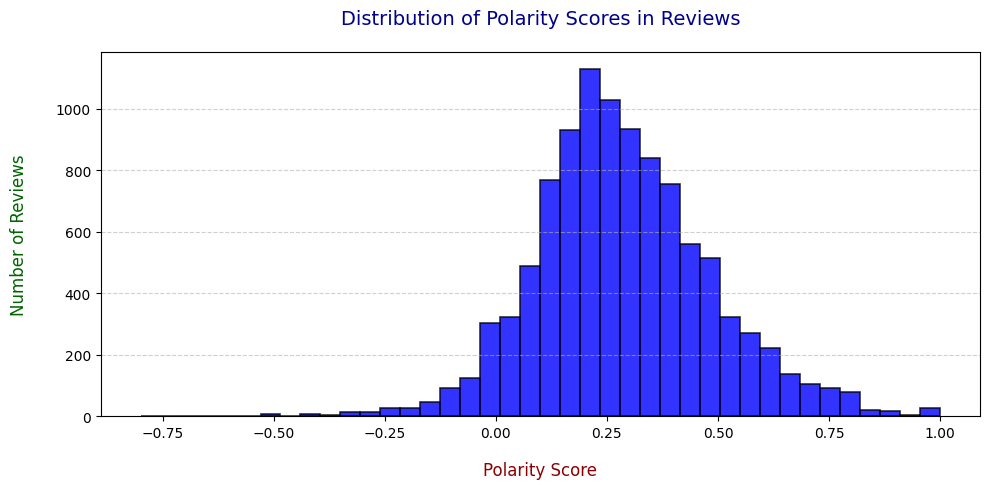

In [22]:
dataset["polarity"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",             # Changed edgecolor to black for better contrast
    linewidth=1.2,                 # Slightly increased the line width
    color="blue",
    figsize=(10,5),
    alpha=0.8                      # Added transparency to the bars for better visibility
)

plt.title("Distribution of Polarity Scores in Reviews", color="darkblue", fontsize=14, pad=20)
plt.xlabel("Polarity Score", labelpad=15, color="darkred", fontsize=12)
plt.ylabel("Number of Reviews", labelpad=20, color="darkgreen", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.6)   # Added gridlines to the y-axis
plt.tight_layout()                              # Adjusted layout to prevent text overlap
plt.show()

*Reviews with negative polarity will be in range of [-1, 0), neutral ones will be 0.0, and positive reviews will have the range of (0, 1].*

*From the histogram above, we know that most of the reviews are distributed in positive sentiments, meaning that what we extracted from our analysis before is true. Statistically, this histogram shows that our data is normally distributed, but not with standard distribution. In conclusion, we know for sure that our analysis about the amount of sentiments from the reviews is correct and corresponds to the histogram above.*

Review Length

In [23]:
dataset["length"] = dataset["reviews"].astype(str).apply(len)

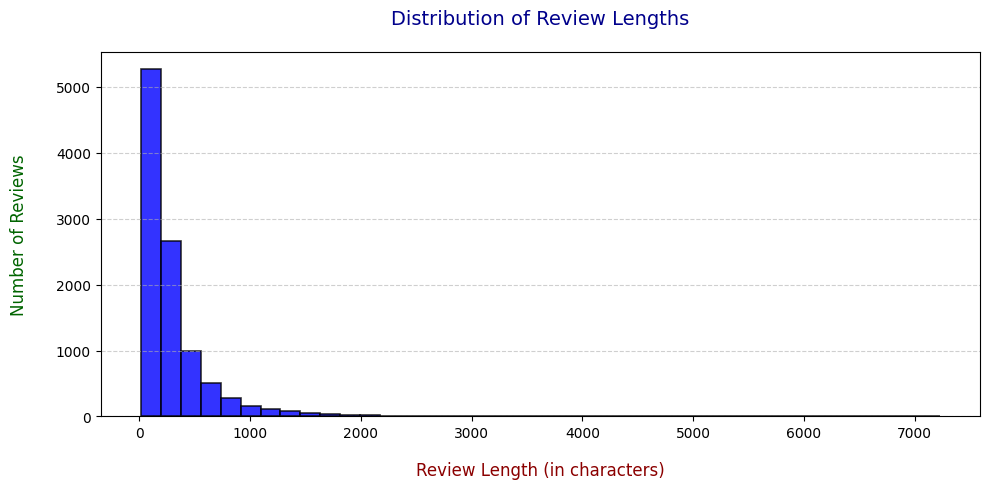

In [24]:
import matplotlib.pyplot as plt

# Assuming `dataset["length"]` is a pandas Series
dataset["length"].plot(
    kind="hist",
    bins=40,
    edgecolor="black",              # Changed edgecolor to black for better contrast
    linewidth=1.2,                  # Slightly increased line width for bar edges
    color="blue",
    figsize=(10,5),
    alpha=0.8                       # Added transparency to make the bars easier to read
)

plt.title("Distribution of Review Lengths", color="darkblue", fontsize=14, pad=20)
plt.xlabel("Review Length (in characters)", labelpad=15, color="darkred", fontsize=12)  # Added context to the x-axis label
plt.ylabel("Number of Reviews", labelpad=20, color="darkgreen", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.6)     # Added y-axis gridlines for easier comparison
plt.tight_layout()                                # Adjusted layout to avoid text clipping
plt.show()


*Based on this, we know that our review has text length between approximately 0-1000 characters. The distribution itself has positive skewness, or in other words it is skewed right, and this means that our reviews rarely has larger length than 1000 characters. Of course, the review that we use here is affected by the text preprocessing phase, so the length might not be the actual value of the review itself as some words might have been omitted already. This will also have the same effect when we count the tatal of words in our reviews.*

Word Counts

In [25]:
dataset["word_counts"] = dataset["reviews"].apply(lambda x: len(str(x).split()))

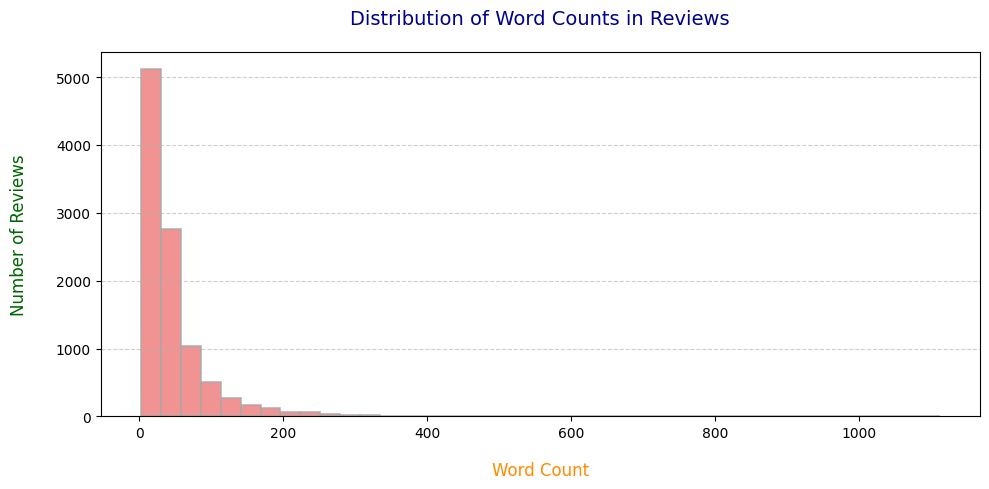

In [26]:
dataset["word_counts"].plot(
    kind="hist",
    bins=40,
    edgecolor="darkgray",          # Changed edge color to dark gray for better contrast
    linewidth=1.2,                 # Slightly thicker edge lines
    color="lightcoral",            # Changed bar color to a soft coral shade
    figsize=(10,5),
    alpha=0.85                     # Added a bit of transparency
)

plt.title("Distribution of Word Counts in Reviews", color="darkblue", fontsize=14, pad=20)
plt.xlabel("Word Count", labelpad=15, color="darkorange", fontsize=12)  # Updated label color
plt.ylabel("Number of Reviews", labelpad=20, color="darkgreen", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.6)  # Added gridlines for better readability
plt.tight_layout()                             # Adjust layout to avoid overlap
plt.show()


*From the figure above, we infer that most of the reviews consist of 0-200 words. Just like before, the distribution is skewed right and the calculation is affected by our text preprocessing phase before.*



---



# N-Gram Analysis

**N-Gram Function**

In [27]:
def Gram_Analysis(Corpus, Gram, N):

  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = list(Stopwords), ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

**Filter The DataFrame Based On Sentiments**

In [28]:
# Use dropna() so the base DataFrame is not affected
Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()

**Unigram of Reviews Based on Sentiments**

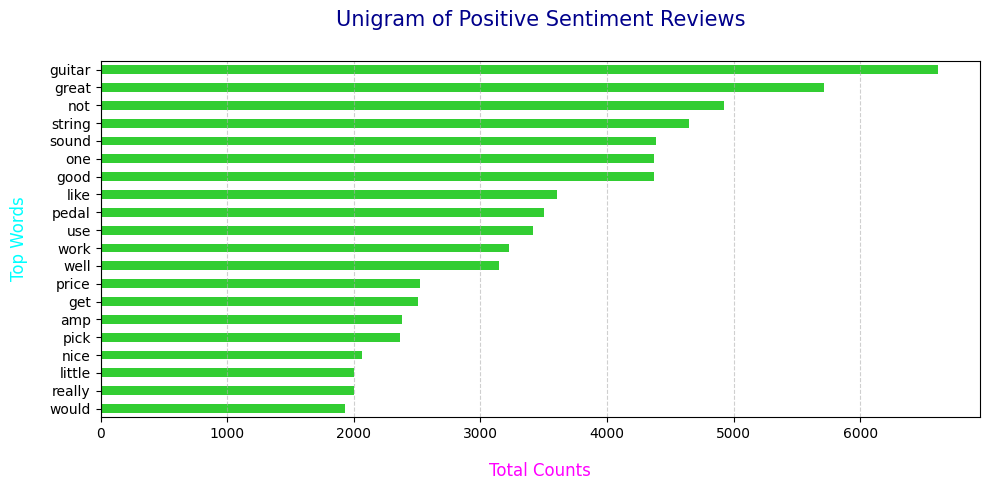

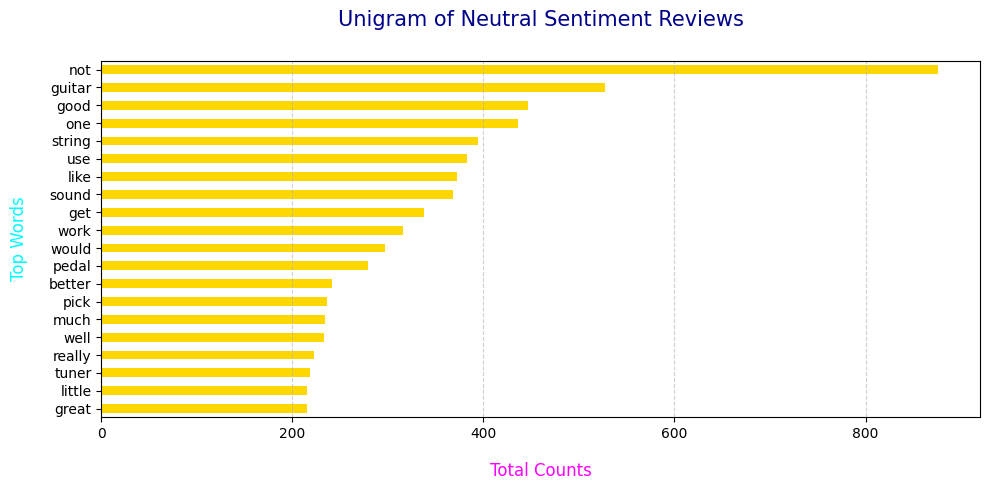

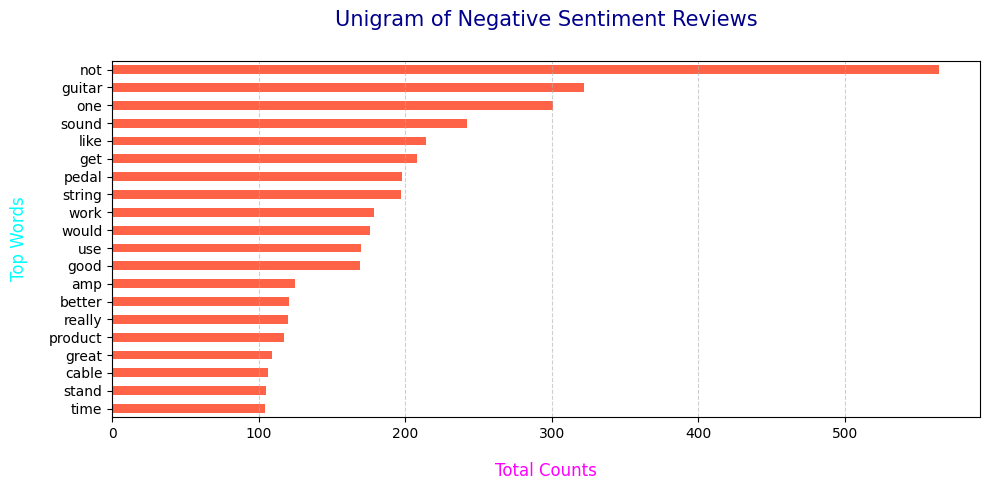

In [29]:
# Finding Unigram for Positive Sentiments
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Positive Sentiments
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="barh",
    color="limegreen",                     # Updated to a more vibrant green
    figsize=(10, 5)
)
plt.title("Unigram of Positive Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=12, labelpad=15)
plt.ylabel("Top Words", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='x', linestyle='--', alpha=0.6)   # Added grid for better comparison
plt.tight_layout()
plt.show()

print()

# Finding Unigram for Neutral Sentiments
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Neutral Sentiments
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="barh",
    color="gold",                            # Updated to a gold color for neutrality
    figsize=(10, 5)
)
plt.title("Unigram of Neutral Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=12, labelpad=15)
plt.ylabel("Top Words", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print()

# Finding Unigram for Negative Sentiments
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Negative Sentiments
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="barh",
    color="tomato",                         # Updated to a softer red
    figsize=(10, 5)
)
plt.title("Unigram of Negative Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=12, labelpad=15)
plt.ylabel("Top Words", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


*These unigrams are not really accurate, because we can clearly see that even for postive sentiments, the top unigram is the wird `guitar` which is an object, though from here we might know that the most frequently bought items are guitars or the complement of it. We should try to find the bigram and see how accurate it can describe each sentiments*

**Bigram of Reviews Based On Sentiments**

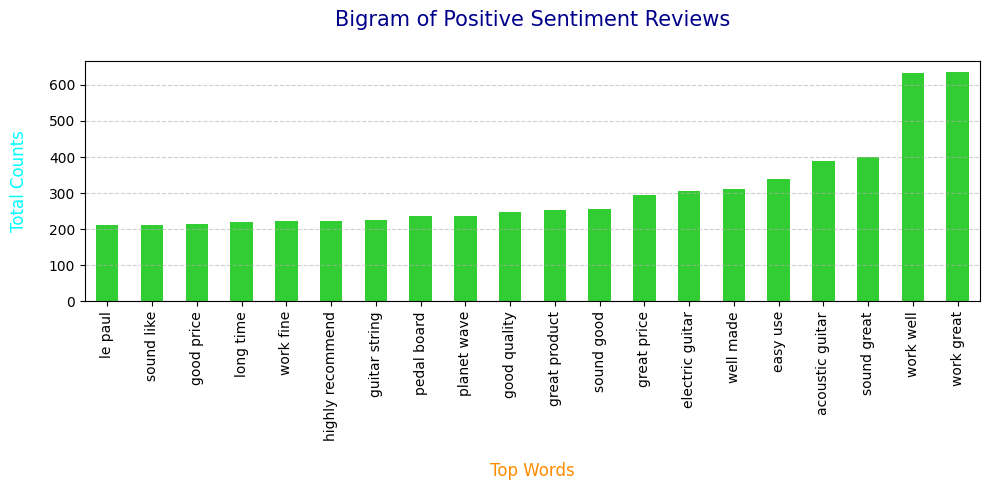

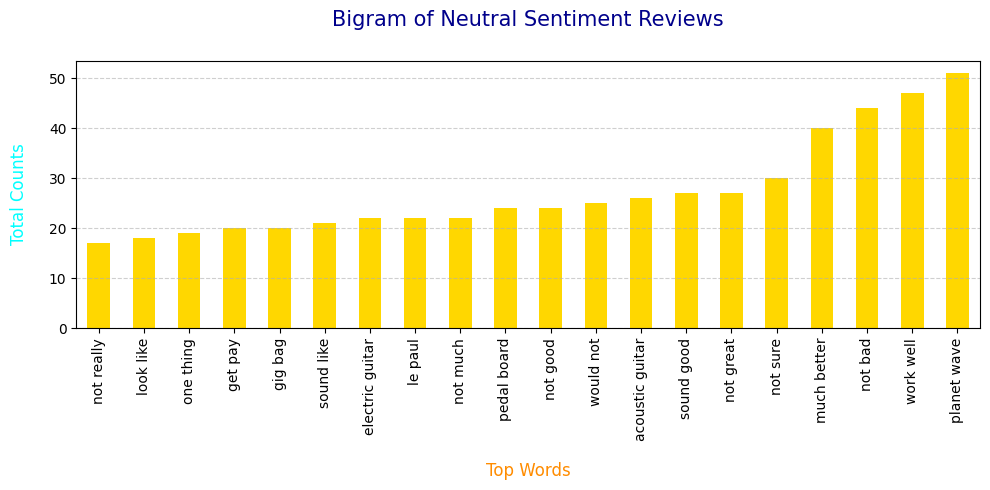

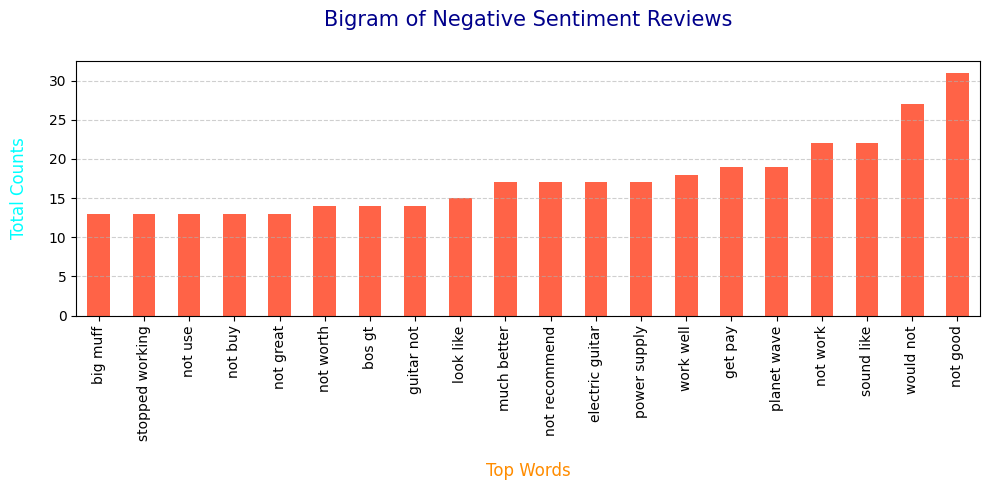

In [30]:
# Finding Bigram for Positive Sentiments
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Positive Sentiments - Horizontal Stacked Bar
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="bar",                              # Changed to a vertical bar plot
    color="limegreen",                       # Updated the color
    figsize=(10, 5)
)
plt.title("Bigram of Positive Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Top Words", color="darkorange", fontsize=12, labelpad=15)  # Updated axis labeling
plt.ylabel("Total Counts", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Added gridlines
plt.tight_layout()
plt.show()

print()

# Finding Bigram for Neutral Sentiments
words = Gram_Analysis(Neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Neutral Sentiments - Horizontal Stacked Bar
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="bar",
    color="gold",
    figsize=(10, 5)
)
plt.title("Bigram of Neutral Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Top Words", color="darkorange", fontsize=12, labelpad=15)
plt.ylabel("Total Counts", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print()

# Finding Bigram for Negative Sentiments
words = Gram_Analysis(Negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Negative Sentiments - Horizontal Stacked Bar
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="bar",
    color="tomato",
    figsize=(10, 5)
)
plt.title("Bigram of Negative Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Top Words", color="darkorange", fontsize=12, labelpad=15)
plt.ylabel("Total Counts", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


*The bigrams work better than the unigrams, because we can actually see some phrases that really describe what a good sentiment is. Although, in some parts we can still see guitar objects as the top words, which make us believe that our interpretation about the most selling items are related to guitars.*

**Trigram of Reviews Based On Sentiments**

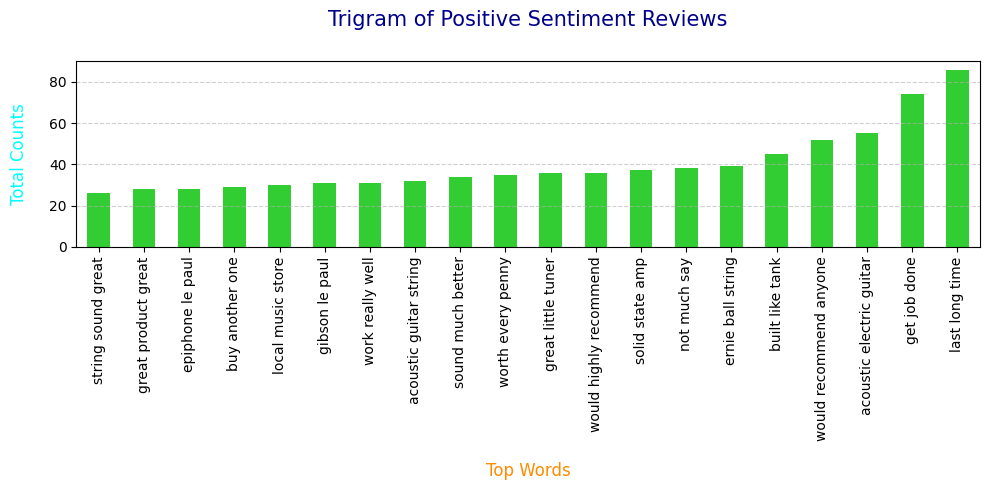

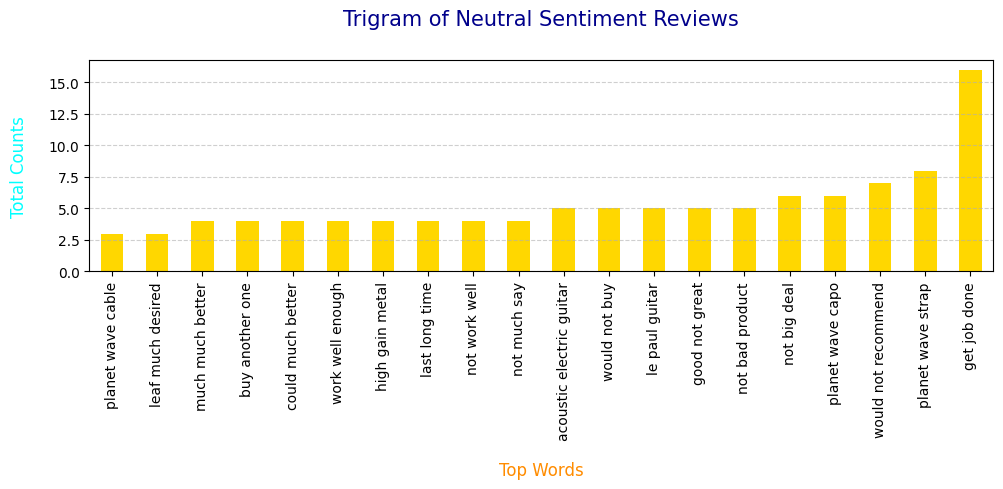

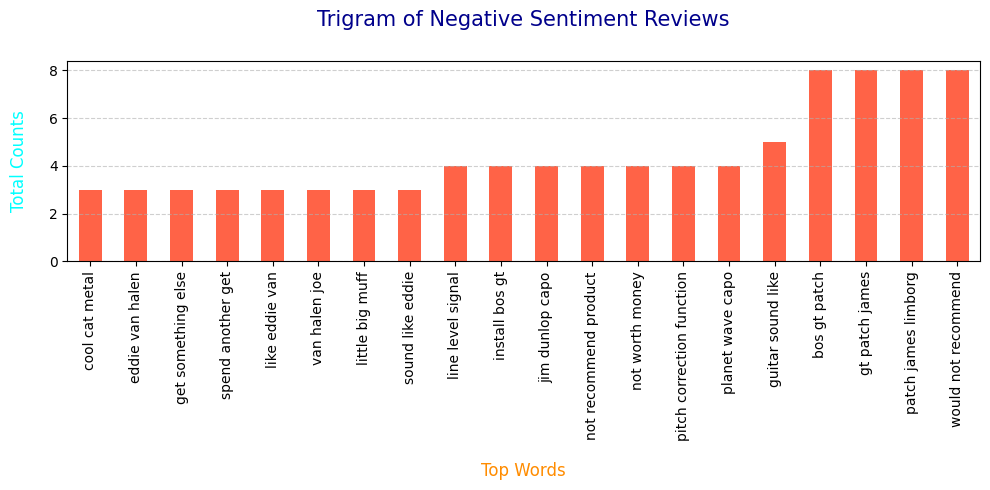

In [31]:
# Finding Trigram for Positive Sentiments
words = Gram_Analysis(Positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Positive Sentiments - Horizontal Stacked Bar
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="bar",                              # Changed to a vertical bar plot
    color="limegreen",                       # Updated the color
    figsize=(10, 5)
)
plt.title("Trigram of Positive Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Top Words", color="darkorange", fontsize=12, labelpad=15)  # Updated axis labeling
plt.ylabel("Total Counts", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Added gridlines
plt.tight_layout()
plt.show()

print()

# Finding Trigram for Neutral Sentiments
words = Gram_Analysis(Neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Neutral Sentiments - Horizontal Stacked Bar
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="bar",
    color="gold",
    figsize=(10, 5)
)
plt.title("Trigram of Neutral Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Top Words", color="darkorange", fontsize=12, labelpad=15)
plt.ylabel("Total Counts", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print()

# Finding Trigram for Negative Sentiments
words = Gram_Analysis(Negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization for Negative Sentiments - Horizontal Stacked Bar
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(
    kind="bar",
    color="tomato",
    figsize=(10, 5)
)
plt.title("Trigram of Negative Sentiment Reviews", loc="center", fontsize=15, color="darkblue", pad=25)
plt.xlabel("Top Words", color="darkorange", fontsize=12, labelpad=15)
plt.ylabel("Total Counts", color="cyan", fontsize=12, labelpad=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


*We can say that the trigrams are slightly better to describe each sentiments, although negative trigrams say a lot about bad products which we can infer from the top words above. From the N-Gram Analysis, we can also see how the decision of not removing `not` in our list of stopwords affects our data as we keep the meaning of negation phrases.*



---



# Word Clouds

**Word Cloud of Reviews with Positive Sentiments**

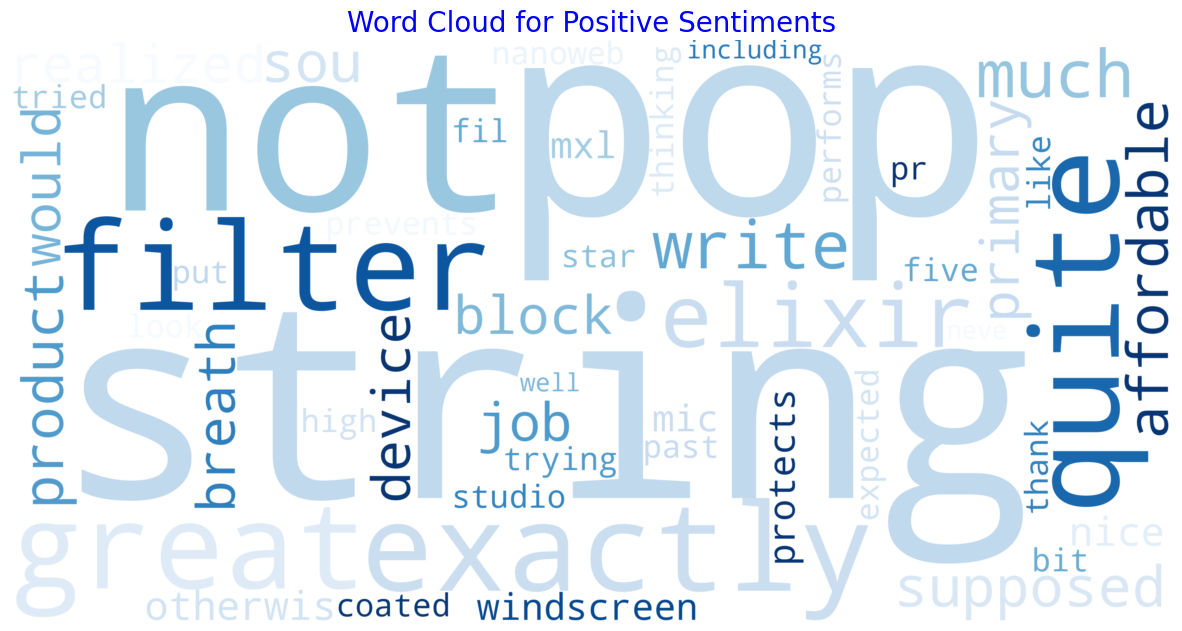

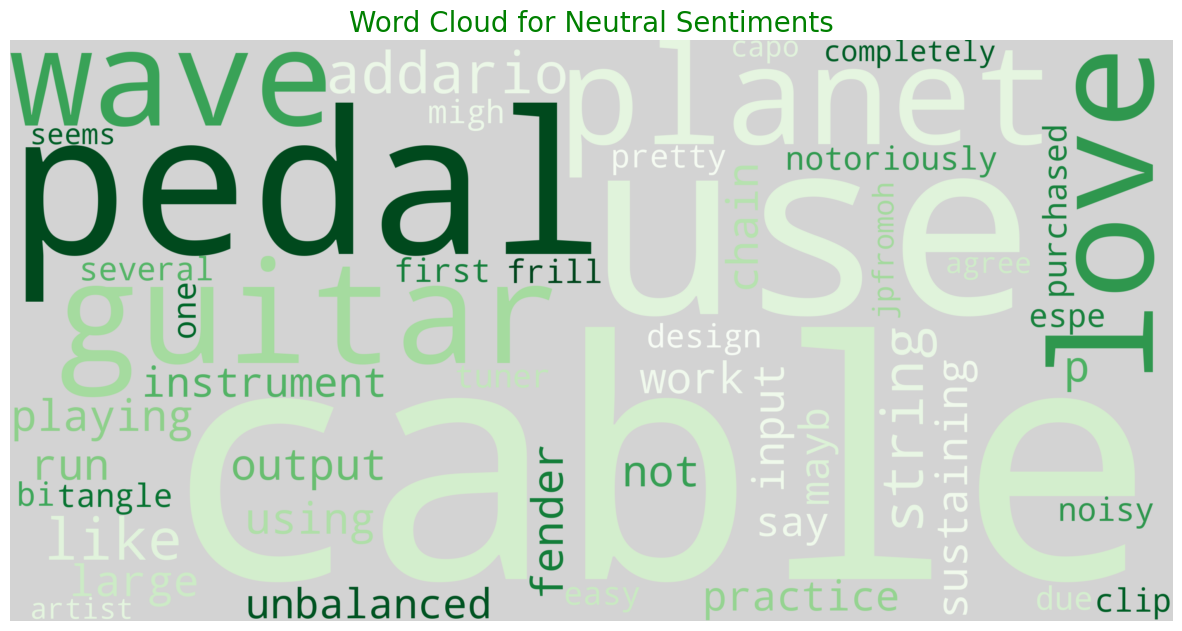

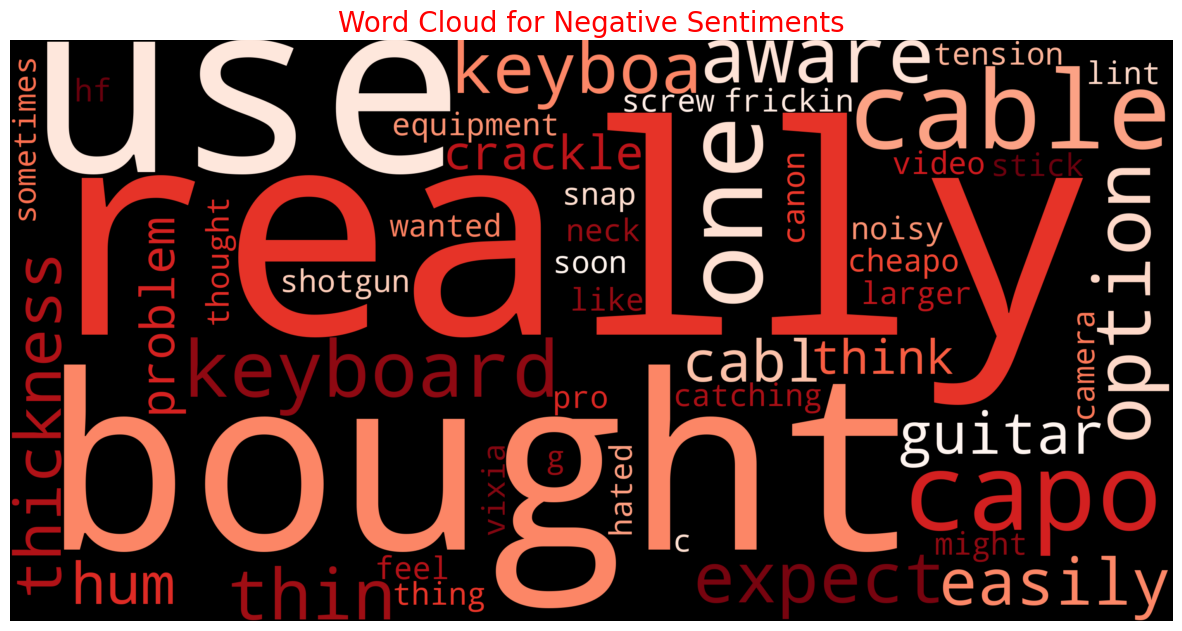

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word Cloud for Positive Sentiments
wordCloud_positive = WordCloud(
    max_words=50,
    width=3000,
    height=1500,
    stopwords=Stopwords,
    background_color='white',        # Background color
    colormap='Blues',                # Colormap for the words
    contour_color='lightblue',       # Contour color for the words
    contour_width=2                  # Width of the contour
).generate(str(Positive["reviews"]))

plt.figure(figsize=(15, 15))
plt.imshow(wordCloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Sentiments", fontsize=20, color='blue')
plt.show()

print()

# Word Cloud for Neutral Sentiments
wordCloud_neutral = WordCloud(
    max_words=50,
    width=3000,
    height=1500,
    stopwords=Stopwords,
    background_color='lightgrey',    # Different background color
    colormap='Greens',               # Colormap for the words
    contour_color='darkgreen',       # Contour color for the words
    contour_width=2
).generate(str(Neutral["reviews"]))

plt.figure(figsize=(15, 15))
plt.imshow(wordCloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Neutral Sentiments", fontsize=20, color='green')
plt.show()

print()

# Word Cloud for Negative Sentiments
wordCloud_negative = WordCloud(
    max_words=50,
    width=3000,
    height=1500,
    stopwords=Stopwords,
    background_color='black',         # Dark background for contrast
    colormap='Reds',                  # Colormap for the words
    contour_color='red',              # Contour color for the words
    contour_width=2
).generate(str(Negative["reviews"]))

plt.figure(figsize=(15, 15))
plt.imshow(wordCloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Sentiments", fontsize=20, color='red')
plt.show()


*From these word clouds, not only we can see words that really describe our sentiments, but just like our N-Grams Analysis we can see objects being discussed in the reviews given.*



---



# Feature Engineering

**Drop Insignificant Columns**

In [33]:
Columns = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "polarity", "length", "word_counts", "overall"]
dataset.drop(columns = Columns, axis = 1, inplace = True)

*We dropped these columns to make our dataset concise. We now have two columns as our independent variables and the last column as dependent variables. To continue, we must encode our label as a set of numbers corresponding to each categories of it.*

**Current State of The Dataset**

In [34]:
dataset.head()

,reviews,sentiment
0,not much write exactly supposed filter pop sou...,Positive
1,product exactly quite affordable not realized ...,Positive
2,primary job device block breath would otherwis...,Positive
3,nice windscreen protects mxl mic prevents pop ...,Positive
4,pop filter great look performs like studio fil...,Positive


**Encoding Our Target Variable**

In [35]:
Encoder = LabelEncoder()
dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])

In [36]:
dataset["sentiment"].value_counts()

,count
sentiment,
2,9022
1,772
0,467


*We had successfully encoded our sentiment into numbers so that our model can easily figure it out. From above, we know that the label `Positive` is encoded into 2, `Neutral` into 1, and `Negative` into 0. Now, we have to give importance of each words in the whole review, i.e. giving them weights. We can do this by using TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer.*

**TF-IDF Vectorizer**

In [37]:
# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(dataset["reviews"])

# Check our matrix shape
X.shape

(10261, 5000)

In [38]:
# Declaring our target variable
y = dataset["sentiment"]

*From the shape, we successfully transformed our reviews with TF-IDF Vectorizer of 7000 top bigram words. Now, as we know from before, our data is kind of imbalanced with very little neutral and negative values compared to positive sentiments. We need to balance our dataset before going into modelling process.*

**Resampling Our Dataset**

*There are many ways to do resampling to an imbalanced dataset, such as SMOTE and Bootstrap Method. We will use SMOTE (Synthetic Minority Oversampling Technique) that will randomly generate new replicates of our undersampling data to balance our dataset.*

In [39]:
Counter(y)

Counter({2: 9022, 1: 772, 0: 467})

In [40]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [41]:
Counter(y_final)

Counter({2: 9022, 1: 9022, 0: 9022})

*Now our data is already balanced as we can see from the counter of each sentiment categories before and after the resampling with SMOTE.*

**Splitting Our Dataset**

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

*We splitted our dataset into 75:25 portion respectively for the training and test set.*



---



# Model Selection and Evaluation

*We do not really know what is the best model that fits our data well. Because of that, we will need to try every classification models available and find the best models using the Confusion Matrix and F1 Score as our main metrics, and the rest of the metrics as our support. First, we should do some cross validation techniques in order to find the best model.*

**Model Building**

*We are using K-Fold Cross Validation on our early dataset (before resampling) because the CV itself is not affected by the imbalanced dataset as it splits the dataset and takes into account every validations. If we use the CV on the balanced dataset that we got from resampling we should be able to get similar result.*

In [43]:
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))

Decision Tree Test Accuracy: 0.8206792812389082
Logistic Regression Test Accuracy: 0.8818828283518491
SVC Test Accuracy: 0.8805184008381876
Random Forest Test Accuracy: 0.8778871066012972
Naive Bayes Test Accuracy: 0.8091794454219505
K-Neighbors Test Accuracy: 0.848942775092009


*We got six models on our sleeves and from the results of 10-Fold Cross Validation, we know that the `Logistic Regression` model is the best model with the highest accuracy, slightly beating the `SVC`. Because of this, we will use the best model in predicting our sentiment, also to tune our parameter and evaluate the end-result of how well the model works.*

**Hyperparameter Tuning**

In [44]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Best Accuracy: 94.88 %
Best Parameters: {'C': 10000.0, 'penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*We got a nice accuracy on our training set, which is 94.80% and from our Grid Search, we are also able to find our optimal hyperparameters. It is time to finish our model using these parameters to get the best model of Logistic Regression.*

**Best Model**

In [45]:
Classifier = LogisticRegression(random_state = 42, C = 6866.488450042998, penalty = 'l2')
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*Now that our model is done, we will test our model on our test set. The metrics that we will evaluate is based on this prediction that we made here.*

**Metrics**

Accuracy On Test Set

In [46]:
accuracy_score(y_test, Prediction)

0.9522683611644747

*Really high accuracy that we got here, 95.21%. Still, we need to look out for the Confusion Matrix and F1 Score to find out about our model performance.*

Confusion Matrix

In [47]:
ConfusionMatrix = confusion_matrix(y_test, Prediction)

Visualizing Our Confusion Matrix

Unnormalized Confusion Matrix


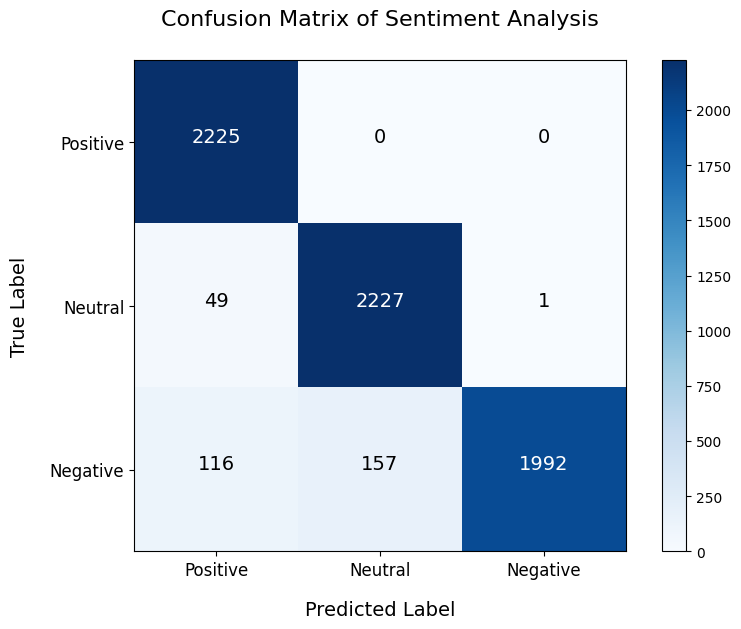

In [48]:
def plot_cm(cm, classes, title, normalized=False, cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title, pad=25, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Unnormalized Confusion Matrix")

    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black", fontsize=14)

    plt.tight_layout()
    plt.xlabel("Predicted Label", fontsize=14, labelpad=15)
    plt.ylabel("True Label", fontsize=14, labelpad=15)
    plt.show()

# Example usage with your confusion matrix
# ConfusionMatrix = np.array([[50, 2, 1], [5, 45, 2], [2, 3, 40]])  # Example confusion matrix
plot_cm(ConfusionMatrix, classes=["Positive", "Neutral", "Negative"],
        title="Confusion Matrix of Sentiment Analysis")

*What we can gain from the Confusion Matrix above is that the model overall works well. It is able to categorize both positive and neutral sentiments correctly, while it seems to struggle a bit at determining negative sentiments. Of course, this is the effect of imbalanced data that we got from our original dataset, and luckily we can minimize the effect thanks to our SMOTE resampling before.*

Classification Scores

In [49]:
print(classification_report(y_test, Prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2225
           1       0.93      0.98      0.96      2277
           2       1.00      0.88      0.94      2265

    accuracy                           0.95      6767
   macro avg       0.95      0.95      0.95      6767
weighted avg       0.95      0.95      0.95      6767



*Overall, to each of our sentiment categories, we got F1 Score of 95%, which is great and because of that we can conclude that our model works well on the dataset.*



---



# Conclusion

**Dataset**



1.   Our dataset contains many features about user reviews on musical instruments. But, we rarely need those features as our model variables because those features are not really important for sentiment analysis.
2.   We might need to omit our part of removing stopwords in our preprocessing phase, because there might be some important words in determining user sentiments in our model.
3.   From our text analysis, we know that most of the transactions made are related to guitars or other string-based instruments. We can say that guitar got a really high attention from the customers' pool and the sellers can emphasize their products on this instruments.



**Model**



1.   We tried almost all classification models available. By using 10-Fold Cross Validation, we get that Logistic Regression Model got the best accuracy and we decided to use this model and tune it.
2.   On our attempt on making prediction to our test set, we also received a nice accuracy and high F1 Score. This means that our model works well on sentiment analysis.
3.   We need to consider more Cross Validation Method, such as Stratified K-Fold so that we do not really need to do resampling on our dataset. Also, we are fine without data scaling, but it is highly suggested to do it.





---



# Sources of Learning

*These articles and notebooks are great and really useful for sentiment analysis and NLP. Check it out!*



1.   [Text Preprocessing in Python: Steps, Tools, and Examples](https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908)
2.   [Sentiment Analysis — ML project from Scratch to Production (Web Application)](https://medium.com/towards-artificial-intelligence/sentiment-analysis-from-scratch-to-production-web-api-3382f19748e8)
3.   [Updated Text Preprocessing techniques for Sentiment Analysis](https://towardsdatascience.com/updated-text-preprocessing-techniques-for-sentiment-analysis-549af7fe412a)
4.   [Amazon Instrument: Sentimental Analysis](https://www.kaggle.com/nayansakhiya/amazon-instrument-sentimental-analysis)
5.   [Sentiment Analysis | Amazon reviews](https://www.kaggle.com/benroshan/sentiment-analysis-amazon-reviews#Story-Generation-and-Visualization-from-reviews)
6.   [SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)



---

